* 퀀트(Quantitative) 
    - 계량투자(양 기반 투자)<-가치투자(장기투자)
    - 과학적 수리적 방식으로 시간에 따라 자산가격이 변하는 대상에 투자
        - 과거의 자료: 
            * 빅데이터 기반 
            * 통계기반 투자
        - 자산의 공정한 가치를 판정 하기위해 노력
    - 알고리즘 트레이딩 발달
        - 인재 사고도 다수 발생:
        - 한맥증권 사태 이후에도 국내 팻핑거 사례
    - 금융상품의 발달
        * 셀사이드
            - 파는쪽
            - 금융 상품 만들어서 팔기
        * 바이사이드
            - 사는쪽
            - 금융상품을 사기

* Moving Average Line 기법
    - 상승과 하강이후에 매수와 매매 신호 발생
    - 타이밍 느림
    - 변폭이 높은 투자 상황에서 불리
* MACD(이동 평균 수렴 확산 지수)
    - Moving Average Convergence Divergence
    - 장단기 이동평균선의 차이를 이용하여 매매신호를 포착하려는 기법
    - 원리
        * 단이평선이 장이평선위로 많이 멀어지게 되면(Divergence)하락할때가 됬다.
        * 단이평선이 장이평선 아래로 많이 멀어졌다 가까워지면 살때가 됬다
    - MAL 기법의 단점인 타이밍 극복
    - 장단기 이평선의 지수이동평균을 사용하여 타이밍 확보
        - 단순이동평균보다 지수이동평균은 최근의 데이터에 더 가중치 부여

In [21]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# 데이터 베이스 사용하기 SQLITE3
def seldata(dstart='2021-07-01',dend='2021-12-20'):
    dbname='../_db/stockdb.db'
    with sqlite3.connect(dbname) as conn:
        cur=conn.cursor()
        cols='sday,sopenp,shighp,slowp,sclosep,svol'
        selsql="select "+cols+" from stockp where sday>='"+dstart+"' and sday<='"+dend+"' order by sday asc"
        sdata=cur.execute(selsql).fetchall()
    return sdata

In [23]:
sdata=seldata()
cols=['sday','sopenp','shighp','slowp','sclosep','svol']
sdf=pd.DataFrame(sdata,columns=cols)
tdf=sdf.set_index('sday')
tdf.head()

,sopenp,shighp,slowp,sclosep,svol
sday,,,,,
2021-07-01,31250,31800,32150,31200,1641174
2021-07-02,31350,31300,31600,31300,1022673
2021-07-05,31850,31600,32250,31250,2594913
2021-07-06,32250,32050,32650,32000,1955885
2021-07-07,31500,31800,31800,31300,1885914


<AxesSubplot:xlabel='sday'>

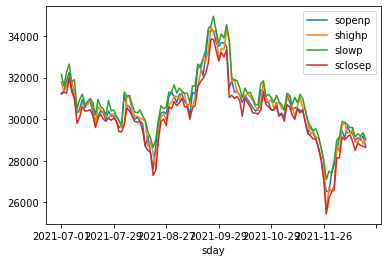

In [24]:
tdf[['sopenp','shighp','slowp','sclosep']].plot()

In [51]:
### 단이평선 5
tdf['shortmv']=tdf['sclosep'].rolling(window=5).mean()
### 장이평선 20
tdf['longmv']=tdf['sclosep'].rolling(window=20).mean()
tdf['macd']=tdf['shortmv']-tdf['longmv']

#tdf['sig']=tdf['macd'].rolling(window=10).mean()
# macd sig 10일
tdf['sig']=tdf['macd'].ewm(span=10).mean()
wdf=tdf.fillna(0)

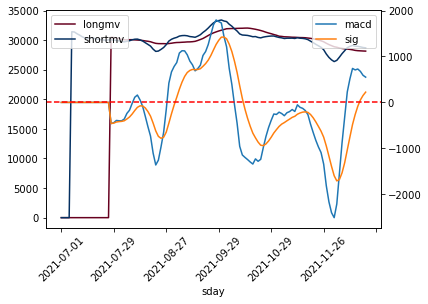

In [90]:
fig,ax1=plt.subplots()

wdf[['longmv','shortmv']].plot( ax=ax1,cmap='RdBu')
ax1.legend(loc=1)
plt.xticks(rotation=45)

ax2 = ax1.twinx()
wdf[['macd','sig']].plot(ax=ax2)
ax1.legend(loc=2)
plt.xticks(rotation=45)
plt.axhline(0,0,30,color='r',linestyle='--')
plt.show()

In [91]:
wdf.head()

,sopenp,shighp,slowp,sclosep,svol,shortmv,longmv,macd,sig,nowpos,hold,cash,timing,cumcash,balance
sday,,,,,,,,,,,,,,,
2021-07-01,31250,31800,32150,31200,1641174,0.0,0.0,0.0,0.0,-1.0,0.0,32000.0,0.0,32000.0,32000.0
2021-07-02,31350,31300,31600,31300,1022673,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-05,31850,31600,32250,31250,2594913,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-06,32250,32050,32650,32000,1955885,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-07,31500,31800,31800,31300,1885914,31410.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,32000.0,32000.0


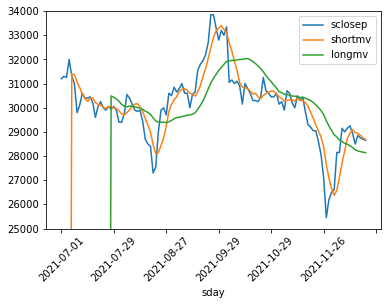

In [92]:
wdf[['sclosep','shortmv','longmv']].plot()
plt.ylim(25000,34000)
plt.xticks(rotation=45)
plt.show()

In [95]:
# 2개월간 10
beforepos=-1 # 이평선 포지션
beforehold=0 # 주식 보유여부
for i,row in wdf.iloc[:,:].iterrows():
    #print(i,'\n',row)
    if row['macd']>row['sig']:
        nowpos=1 ## 매수 포지션
    else:
        nowpos=-1
    if(row['longmv']==0):
        nowpos=-1
    wdf.loc[i,'nowpos']=nowpos # 현재 포지션
    
    if nowpos>beforepos and beforehold==0: # 매수신호
        timing=1
        hold=1
        wdf.loc[i,'cash']=-row['sclosep']
    elif nowpos<beforepos and beforehold==1:
        timing=-1
        hold=0
        wdf.loc[i,'cash']=row['sclosep']
    else:
        timing=0
        hold=beforehold
        
    wdf.loc[i,'hold']=hold # 주식 보유 여부
    wdf.loc[i,'timing']=timing
    beforepos=nowpos
    beforehold=hold
wdf['cash'][0]=32000
wdf['cumcash']=wdf['cash'].cumsum()
wdf['balance']=wdf['sclosep']*wdf['hold']+wdf['cumcash']
scols=['sclosep','longmv','nowpos','timing','hold','cash','cumcash','balance']
print('시작가:',wdf['sclosep'][0],
      ' 종가:',wdf['sclosep'][-1],
      '차이:',wdf['sclosep'][-1]-wdf['sclosep'][0],
      '잔고:',wdf['balance'][-1],
      '수익:',wdf['balance'][-1]-wdf['balance'][0],
     )
wdf[scols].head(30)


시작가: 31200  종가: 28650 차이: -2550 잔고: 32950.0 수익: 950.0


<ipython-input-95-e5e77a3c2a64>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wdf['cash'][0]=32000


,sclosep,longmv,nowpos,timing,hold,cash,cumcash,balance
sday,,,,,,,,
2021-07-01,31200,0.0,-1.0,0.0,0.0,32000.0,32000.0,32000.0
2021-07-02,31300,0.0,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-05,31250,0.0,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-06,32000,0.0,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-07,31300,0.0,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-08,31000,0.0,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-09,29800,0.0,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-12,30100,0.0,-1.0,0.0,0.0,0.0,32000.0,32000.0
2021-07-13,30600,0.0,-1.0,0.0,0.0,0.0,32000.0,32000.0


(30.0, 90.0)

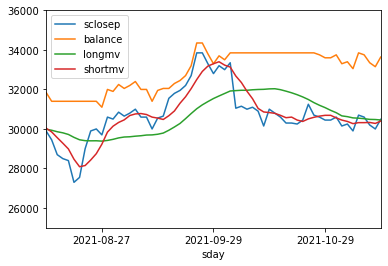

In [94]:
wdf[['sclosep','balance','longmv','shortmv']].plot()
plt.ylim(25000,36000)
plt.xlim(30,90)